# Process data

### Important

In order to process the airport, flight, and weather data, you must already have it available. If you have not already acquired the data, open notebook `01_get_data` and run all its cells.

In [3]:
%matplotlib inline
import os
import pandas as pd
import re  # regular expressions

In [4]:
data_dir = os.path.join('..','resources','data')

In [5]:
os.listdir(data_dir)

['05-2019.csv',
 '06-2019.csv',
 '07-2019.csv',
 '08-2019.csv',
 '09-2019.csv',
 '10-2019.csv',
 '11-2019.csv',
 '12-2019.csv',
 'gadb_postgresql_create_airports_table.sql',
 'GlobalAirportDatabase_Create_PostgreSQL.zip',
 'historical-flight-and-weather-data.zip']

In [10]:
primary_source_files = list(filter(
                            lambda item: re.fullmatch(
                                '\d{2}\-2019\.csv',
                                item,
                                flags=re.I
                            ) is not None,
                            os.listdir(data_dir)
                        ))

secondary_source_file = 'gadb_postgresql_create_airports_table.sql'

## Primary Data Set

In [11]:
primary_df = pd.concat([
    pd.read_csv(os.path.join(data_dir,filename))
    for filename in primary_source_files
])

primary_df_rows, primary_df_cols = primary_df.shape

print(f"{primary_df_rows:,} rows × {primary_df_cols:,} columns")

5,512,903 rows × 35 columns


In [12]:
primary_df.head()

,carrier_code,flight_number,origin_airport,destination_airport,date,scheduled_elapsed_time,tail_number,departure_delay,arrival_delay,delay_carrier,...,HourlyPrecipitation_x,HourlyStationPressure_x,HourlyVisibility_x,HourlyWindSpeed_x,STATION_y,HourlyDryBulbTemperature_y,HourlyPrecipitation_y,HourlyStationPressure_y,HourlyVisibility_y,HourlyWindSpeed_y
0,AS,121,SEA,ANC,2019-05-01,215,N615AS,-8,-16,0,...,0.0,29.59,10.0,8.0,7.027253e+10,42.0,0.0,30.16,10.0,3.0
1,F9,402,LAX,DEN,2019-05-01,147,N701FR,17,-4,0,...,0.0,29.65,10.0,3.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0
2,F9,662,SFO,DEN,2019-05-01,158,N346FR,44,27,0,...,0.0,29.98,10.0,6.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0
3,F9,790,PDX,DEN,2019-05-01,156,N332FR,24,10,0,...,0.0,29.98,10.0,0.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0
4,AS,108,ANC,SEA,2019-05-01,210,N548AS,-9,-31,0,...,0.0,30.18,10.0,5.0,7.279302e+10,44.0,0.0,29.58,10.0,7.0


In [13]:
# Get data types and number of null values for each column
pd.concat(
    [
        primary_df.dtypes,
        primary_df.isna().sum()
    ],
    axis=1,
    keys=['data_type','null_count']
)

,data_type,null_count
carrier_code,object,0
flight_number,int64,0
origin_airport,object,0
destination_airport,object,0
date,object,0
scheduled_elapsed_time,int64,0
tail_number,object,13556
departure_delay,int64,0
arrival_delay,int64,0
delay_carrier,int64,0


**Note:** Eventually, `cancelled_code` will be our target column for a machine-learning algorithm.  
Because the column in the source data is `cancelled_code` and not `canceled_code`, the double-l spelling will be used in this work.

In [14]:
# Examine the `carrier_code` column
primary_df.carrier_code.value_counts()

AA    1438798
DL    1207720
UA    1070050
WN     918320
AS     304198
B6     199314
NK     142041
F9      97482
G4      71728
HA      63252
Name: carrier_code, dtype: int64

### What do the codes mean?

According to the United States Department of Transportation Bureau of Transportation Statistics Airlines and Airports data, [Airline Codes](https://www.bts.gov/topics/airlines-and-airports/airline-codes) document:

**AIRLINE CODES:**
- `AA`-American Airlines Inc.
- `AS`-Alaska Airlines Inc.
- `B6`-JetBlue Airways
- `DL`-Delta Air Lines Inc.
- `F9`-Frontier Airlines Inc.
- `G4`-Allegiant Air
- `HA`-Hawaiian Airlines Inc.
- `NK`-Spirit Air Lines
- `UA`-United Air Lines Inc.
- `WN`-Southwest Airlines Co.

In [15]:
# Examine the `flight_number` column
# Are they unique?
primary_df.flight_number.duplicated(keep=False).sum()

5512864

They very much are not unique.

In [16]:
# What about the combination of `carrier_code` and `flight_number`?
primary_df[['carrier_code','flight_number']].duplicated(keep=False).sum()

5512259

Also not unique.

In [17]:
# Combine `year`, `month`, and `day` into a single `string` in the same format as the `date` column
# and check for equality against the actual date column.

# Check only a few rows
(
    primary_df[['year','month','day']][:3]
    .apply(lambda row: '-'.join([val.zfill(2) for val in row.values.astype(str)]), axis=1)
    .equals(
        primary_df.date[:3]
    )
)

# Check all the rows
# (
#     primary_df[['year','month','day']]
#     .apply(lambda row: '-'.join([val.zfill(2) for val in row.values.astype(str)]), axis=1)
#     .equals(
#         primary_df.date
#     )
# )

True

**Note:** The all-rows check, above, is commented out because it takes a long time, but when run, it does show equality between the entire `date` series and the combined `year`-`month`-`day` series.

Because `year`, `month`, and `day` were originally stored as `int64` values, this also tells us that all the values in `date` are properly formatted (no leading or trailing spaces, *etc*.).

The data is therefore redundant, and we don't need both.

`weekday` is likewise redundant, since it can be calculated from `date`.

In [18]:
# Drop redundant date columns
primary_df.drop(
    columns=['year','month','day','weekday'],
    errors='ignore',
    inplace=True
)

primary_df_rows, primary_df_cols = primary_df.shape

print(f"{primary_df_rows:,} rows × {primary_df_cols:,} columns")

5,512,903 rows × 31 columns


In [19]:
# Examine `cancelled_code` column
primary_df.cancelled_code.value_counts()

N    5426150
B      41919
A      23451
C      21370
D         13
Name: cancelled_code, dtype: int64

### What do the codes mean?

According to the United States Department of Transportation Bureau of Transportation Statistics Airlines and Airports data, [Number 14 - On-Time Reporting](https://www.bts.gov/topics/airlines-and-airports/number-14-time-reporting):

**CANCELLATION CODES**
- `A`-Carrier Caused
- `B`-Weather
- `C`-National Aviation System
- `D`-Security

\[`N` is not on the list and represents "None" or "Not cancelled".\]

We are only interested in flights that were cancelled due to weather, so we will keep only rows with `cancelled_code` `B` or `N`.

In [20]:
primary_df = primary_df.loc[primary_df.cancelled_code.isin(['B','N'])]

primary_df_rows, primary_df_cols = primary_df.shape

print(f"{primary_df_rows:,} rows × {primary_df_cols:,} columns")

5,468,069 rows × 31 columns


In [21]:
# Check that there are now only `B` and `N` values
primary_df.cancelled_code.value_counts()

N    5426150
B      41919
Name: cancelled_code, dtype: int64

In [22]:
# Convert `cancelled_code` column into boolean `cancelled` column, where
# `B` = True (*was* cancelled) and `N` = False (*was not* cancelled)

try:
    print("Converting cancelled_code column to boolean… ", end="")
    primary_df.cancelled_code = (primary_df.cancelled_code == 'B')
    primary_df.rename(columns={'cancelled_code':'cancelled'},inplace=True)
    print()
except AttributeError:
    print("Column has already been processed.")

primary_df.cancelled.value_counts()

Converting cancelled_code column to boolean… 


False    5426150
True       41919
Name: cancelled, dtype: int64

In [23]:
# How many flights were cancelled|not cancelled vs. how many departed|arrived

departed = ~primary_df.actual_departure_dt.isna()
arrived = ~primary_df.actual_arrival_dt.isna()

mult_ix = pd.MultiIndex.from_tuples([
    ('departed',True),
    ('departed',False),
    ('arrived',True),
    ('arrived',False),
])

mult_cols = pd.MultiIndex.from_tuples([
    ('cancelled',False),
    ('cancelled',True)
])

pd.DataFrame(
    data=[
        [
            primary_df.loc[(~primary_df.cancelled) & (departed)].shape[0],
            primary_df.loc[(primary_df.cancelled) & (departed)].shape[0]
        ],
        [
            primary_df.loc[(~primary_df.cancelled) & (~departed)].shape[0],
            primary_df.loc[(primary_df.cancelled) & (~departed)].shape[0]
        ],
        [
            primary_df.loc[(~primary_df.cancelled) & (arrived)].shape[0],
            primary_df.loc[(primary_df.cancelled) & (arrived)].shape[0]
        ],
        [
            primary_df.loc[(~primary_df.cancelled) & (~arrived)].shape[0],
            primary_df.loc[(primary_df.cancelled) & (~arrived)].shape[0]
        ]
    ],
    index=mult_ix,
    columns=mult_cols
)

cancelled       
                   False   True
departed True    5426150   1854
         False         0  40065
arrived  True    5424261      0
         False      1889  41919

In [24]:
# Does anything stand out for cancelled flights that still departed?
primary_df.loc[primary_df.cancelled & departed].head().transpose()

,16715,17002,17815,18640,18750
carrier_code,AA,AA,AA,AA,AA
flight_number,1393,346,2761,1271,5821
origin_airport,OKC,DFW,DFW,IAH,DFW
destination_airport,DFW,MSY,STL,DFW,ELP
date,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01
scheduled_elapsed_time,69,85,105,75,104
tail_number,N751UW,N357PV,N971TW,N898NN,N243LR
departure_delay,176,83,111,113,28
arrival_delay,0,0,0,0,0
delay_carrier,0,0,0,0,0


In [25]:
# What about non-cancelled flights that didn't arrive?
primary_df.loc[~primary_df.cancelled & ~arrived].head().transpose()

,5154,12535,13657,16277,17368
carrier_code,AS,AA,WN,WN,UA
flight_number,55,2028,2272,2212,6296
origin_airport,SCC,MEM,PDX,ABQ,IAD
destination_airport,BRW,DFW,DAL,DAL,DFW
date,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01
scheduled_elapsed_time,45,99,230,105,209
tail_number,N609AS,N749US,N931WN,N788SA,N87353
departure_delay,29,398,-2,-5,212
arrival_delay,0,0,0,0,0
delay_carrier,0,0,0,0,0


In [26]:
primary_obj_cols = primary_df.select_dtypes('object').columns

primary_obj_cols.tolist()

['carrier_code',
 'origin_airport',
 'destination_airport',
 'date',
 'tail_number',
 'scheduled_departure_dt',
 'scheduled_arrival_dt',
 'actual_departure_dt',
 'actual_arrival_dt']

`carrier_code`, `origin_airport`, `destination_airport`, and `tail_number` are legitimate `string`/`text` columns.

`carrier_code` and `tail_number` are for identification purposes, only, though, and so will not be features for the machine-learning model.

`origin_airport` and `destination_airport` will serve as foreign keys to join to the airport data from the secondary dataset.

`date`, `scheduled_departure_dt`, `scheduled_arrival_dt`, `actual_departure_dt`, `actual_arrival_dt` are currently `string`s, but they can be converted to `date`, `datetime` or `timestamp` formats, if necessary prior to uploading to the SQL database.

`actual_departure_dt` and `actual_arrival_dt` can be stored in the database, but they absolutely should ***not*** be used as features for machine learning, as their presence or absence *defines* what it means for a flight to be cancelled, which is exactly what we want the model to predict.

In [27]:
# Import dependencies
import matplotlib.pyplot as plt

In [28]:
# Display the df with all columns
pd.set_option('display.max_columns', None)
primary_df.head()

,carrier_code,flight_number,origin_airport,destination_airport,date,scheduled_elapsed_time,tail_number,departure_delay,arrival_delay,delay_carrier,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircarft_arrival,cancelled,scheduled_departure_dt,scheduled_arrival_dt,actual_departure_dt,actual_arrival_dt,STATION_x,HourlyDryBulbTemperature_x,HourlyPrecipitation_x,HourlyStationPressure_x,HourlyVisibility_x,HourlyWindSpeed_x,STATION_y,HourlyDryBulbTemperature_y,HourlyPrecipitation_y,HourlyStationPressure_y,HourlyVisibility_y,HourlyWindSpeed_y
0,AS,121,SEA,ANC,2019-05-01,215,N615AS,-8,-16,0,0,0,0,0,False,2019-05-01 00:40:00,2019-05-01 03:15:00,2019-05-01 00:32:00,2019-05-01 02:59:00,7.279302e+10,49.0,0.0,29.59,10.0,8.0,7.027253e+10,42.0,0.0,30.16,10.0,3.0
1,F9,402,LAX,DEN,2019-05-01,147,N701FR,17,-4,0,0,0,0,0,False,2019-05-01 00:59:00,2019-05-01 04:26:00,2019-05-01 01:16:00,2019-05-01 04:22:00,7.229502e+10,58.0,0.0,29.65,10.0,3.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0
2,F9,662,SFO,DEN,2019-05-01,158,N346FR,44,27,0,0,0,0,27,False,2019-05-01 00:50:00,2019-05-01 04:28:00,2019-05-01 01:34:00,2019-05-01 04:55:00,7.249402e+10,51.0,0.0,29.98,10.0,6.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0
3,F9,790,PDX,DEN,2019-05-01,156,N332FR,24,10,0,0,0,0,0,False,2019-05-01 00:55:00,2019-05-01 04:31:00,2019-05-01 01:19:00,2019-05-01 04:41:00,7.269802e+10,48.0,0.0,29.98,10.0,0.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0
4,AS,108,ANC,SEA,2019-05-01,210,N548AS,-9,-31,0,0,0,0,0,False,2019-05-01 00:10:00,2019-05-01 04:40:00,2019-05-01 00:01:00,2019-05-01 04:09:00,7.027253e+10,43.0,0.0,30.18,10.0,5.0,7.279302e+10,44.0,0.0,29.58,10.0,7.0


In [31]:
# Create a new df for visualization
simple_viz_df = primary_df[["carrier_code", "date", "cancelled"]]
simple_viz_df.head()

,carrier_code,date,cancelled
0,AS,2019-05-01,False
1,F9,2019-05-01,False
2,F9,2019-05-01,False
3,F9,2019-05-01,False
4,AS,2019-05-01,False


In [69]:
# Group by carrier_code and aggregate cancelled

carrier_df = simple_viz_df.groupby('carrier_code').agg({"date": "count"})
carrier_df

,date
carrier_code,
AA,1422302
AS,301914
B6,198583
DL,1203963
F9,96609
G4,71676
HA,62969
NK,141106
UA,1059668


In [70]:
carrier_df = carrier_df.reset_index(level=0)

In [72]:
carrier_list = carrier_df["carrier_code"].to_list()
carrier_list

['AA', 'AS', 'B6', 'DL', 'F9', 'G4', 'HA', 'NK', 'UA', 'WN']

In [73]:
carrier_total_flights = carrier_df["date"].to_list()
carrier_total_flights

[1422302,
 301914,
 198583,
 1203963,
 96609,
 71676,
 62969,
 141106,
 1059668,
 909279]

Text(0, 0.5, 'Number of Flights in Millions')

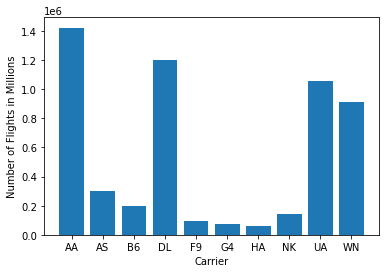

In [77]:
x_axis = carrier_list
y_axis = carrier_total_flights

plt.bar(x_axis, y_axis)

# Create labels for the x and y axes.
plt.xlabel("Carrier")
plt.ylabel("Number of Flights in Millions")

In [78]:
simple_viz_df.head()

,carrier_code,date,cancelled
0,AS,2019-05-01,False
1,F9,2019-05-01,False
2,F9,2019-05-01,False
3,F9,2019-05-01,False
4,AS,2019-05-01,False


In [99]:
AS_cancelled = simple_viz_df[["carrier_code"]=="AS"] & simple_viz_df[["cancelled"] is "False"]

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\rysul\AppData\Local\Temp\ipykernel_20624\1554290051.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  AS_cancelled = simple_viz_df[["carrier_code"]=="AS"] & simple_viz_df[["cancelled"] is "False"]
C:\Users\rysul\AppData\Local\Temp\ipykernel_20624\1554290051.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  AS_cancelled = simple_viz_df[["carrier_code"]=="AS"] & simple_viz_df[["cancelled"] is "False"]
C:\Users\rysul\AppData\Local\Temp\ipykernel_20624\1554290051.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  AS_cancelled = simple_viz_df[["carrier_code"]=="AS"] & simple_viz_df[["cancelled"] is "False"]
C:\Users\rysul\AppData\Local\Temp\ipykernel_20624\1554290051.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  AS_cancelled = simple_viz_df[["carrier_code"]=="AS"] & simple_viz_df[["cancelled"] is "False"]


KeyError: False

## Secondary Data Set

In [21]:
# Assign the Global Airport Database setup file as a string
with open(os.path.join(data_dir,secondary_source_file)) as gadb:
    gadb_text = gadb.read()

In [22]:
print(gadb_text[:1500], '\n…')

/*
   Global Airport Database
   Author: Arash Partow
   URL: www.partow.net/miscellaneous/airportdatabase/index.html

   Copyright notice:
   Free use of the Global Airport Database is permitted under the
   guidelines and in accordance with the most current version of
   the MIT License.
   http://www.opensource.org/licenses/MIT
*/

create table airports
             (
               icao_code   char   ( 4)       ,
               iata_code   char   ( 3)       ,
               name        varchar(50)       ,
               city        varchar(50)       ,
               country     varchar(50)       ,
               lat_deg     int               ,
               lat_min     int               ,
               lat_sec     int               ,
               lat_dir     char   ( 1)       ,
               lon_deg     int               ,
               lon_min     int               ,
               lon_sec     int               ,
               lon_dir     char   ( 1)       ,
               

In [23]:
# Split the text on double-linebreaks.
gadb_split = gadb_text.split('\n\n')

In [24]:
len(gadb_split)

4

In [25]:
# The first two segments are header information
print(gadb_split[:2])

['/*\n   Global Airport Database\n   Author: Arash Partow\n   URL: www.partow.net/miscellaneous/airportdatabase/index.html', '   Copyright notice:\n   Free use of the Global Airport Database is permitted under the\n   guidelines and in accordance with the most current version of\n   the MIT License.\n   http://www.opensource.org/licenses/MIT\n*/']


In [26]:
# The third segment (index 2) is the table setup
print(gadb_split[2])

create table airports
             (
               icao_code   char   ( 4)       ,
               iata_code   char   ( 3)       ,
               name        varchar(50)       ,
               city        varchar(50)       ,
               country     varchar(50)       ,
               lat_deg     int               ,
               lat_min     int               ,
               lat_sec     int               ,
               lat_dir     char   ( 1)       ,
               lon_deg     int               ,
               lon_min     int               ,
               lon_sec     int               ,
               lon_dir     char   ( 1)       ,
               altitude    int               ,
               lat_decimal double precision  ,
               lon_decimal double precision  ,
               id          serial primary key
             );


In [27]:
# The last segment (index 3) is the data-insertion instructions.

# Capitalize keywords and combine VALUES into single INSERT INTO instruction
gadb_split[3] = re.sub('insert into airports values ', 'INSERT INTO airports (\n    icao_code,\n    iata_code,\n    name,\n    city,\n    country,\n    lat_deg,\n    lat_min,\n    lat_sec,\n    lat_dir,\n    lon_deg,\n    lon_min,\n    lon_sec,\n    lon_dir,\n    altitude,\n    lat_decimal,\n    lon_decimal\n)\nVALUES\n    ', gadb_split[3], count=1, flags=re.I)
gadb_split[3] = re.sub('\);\ninsert into airports values \(', '),\n    (', gadb_split[3], flags=re.I)

In [28]:
print(gadb_split[3][:1500],'\n…')

INSERT INTO airports (
    icao_code,
    iata_code,
    name,
    city,
    country,
    lat_deg,
    lat_min,
    lat_sec,
    lat_dir,
    lon_deg,
    lon_min,
    lon_sec,
    lon_dir,
    altitude,
    lat_decimal,
    lon_decimal
)
VALUES
    ('AYGA', 'GKA', 'GOROKA', 'GOROKA', 'PAPUA NEW GUINEA', 006, 004, 054, 'S', 145, 023, 030, 'E', 01610, -6.082, 145.392),
    ('AYLA', 'LAE', 'N/A', 'LAE', 'PAPUA NEW GUINEA', 000, 000, 000, 'U', 000, 000, 000, 'U', 00000, 0.000, 0.000),
    ('AYMD', 'MAG', 'MADANG', 'MADANG', 'PAPUA NEW GUINEA', 005, 012, 025, 'S', 145, 047, 019, 'E', 00007, -5.207, 145.789),
    ('AYMH', 'HGU', 'MOUNT HAGEN', 'MOUNT HAGEN', 'PAPUA NEW GUINEA', 005, 049, 034, 'S', 144, 017, 046, 'E', 01643, -5.826, 144.296),
    ('AYNZ', 'LAE', 'NADZAB', 'NADZAB', 'PAPUA NEW GUINEA', 006, 034, 011, 'S', 146, 043, 034, 'E', 00073, -6.570, 146.726),
    ('AYPY', 'POM', 'PORT MORESBY JACKSONS INTERNATIONAL', 'PORT MORESBY', 'PAPUA NEW GUINEA', 009, 026, 036, 'S', 147, 013, 012